# VAR Estimation and Forecasting

In this notebook, we illustrate standard procedures related to reduced form VAR estimation. In particular, we discuss and develop code for the purpose of estimating a VAR model, conducting model selection and diagnostics, and forecasting. The data used for this illustration includes observations of U.S. real GDP, inflation, and the one year Treasury rate.

In [ ]:
#----------------------- Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mmetrics import VARModel
from mmetrics import VARLagOrderSelector
from mmetrics import AutocovarianceModel, estimate_residual_autocorrelations
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(suppress=True)

In [26]:
#----------------------- Import the data
# Real GDP, FRED code: GDPC1
rgdp_df = pd.read_csv("Data/rgdp.csv")
rgdp = rgdp_df["GDPC1"].to_numpy()
log_rgdp = np.log(rgdp)

# CPI, FRED code: CPIAUCSL
cpi_df = pd.read_csv("Data/cpi.csv")
cpi = cpi_df["CPI"].to_numpy()
log_cpi = np.log(cpi)

# One year Treasury rate, FRED code: GS1
gs1_df = pd.read_csv("Data/gs1.csv")
gs1 = gs1_df["GS1"].to_numpy()

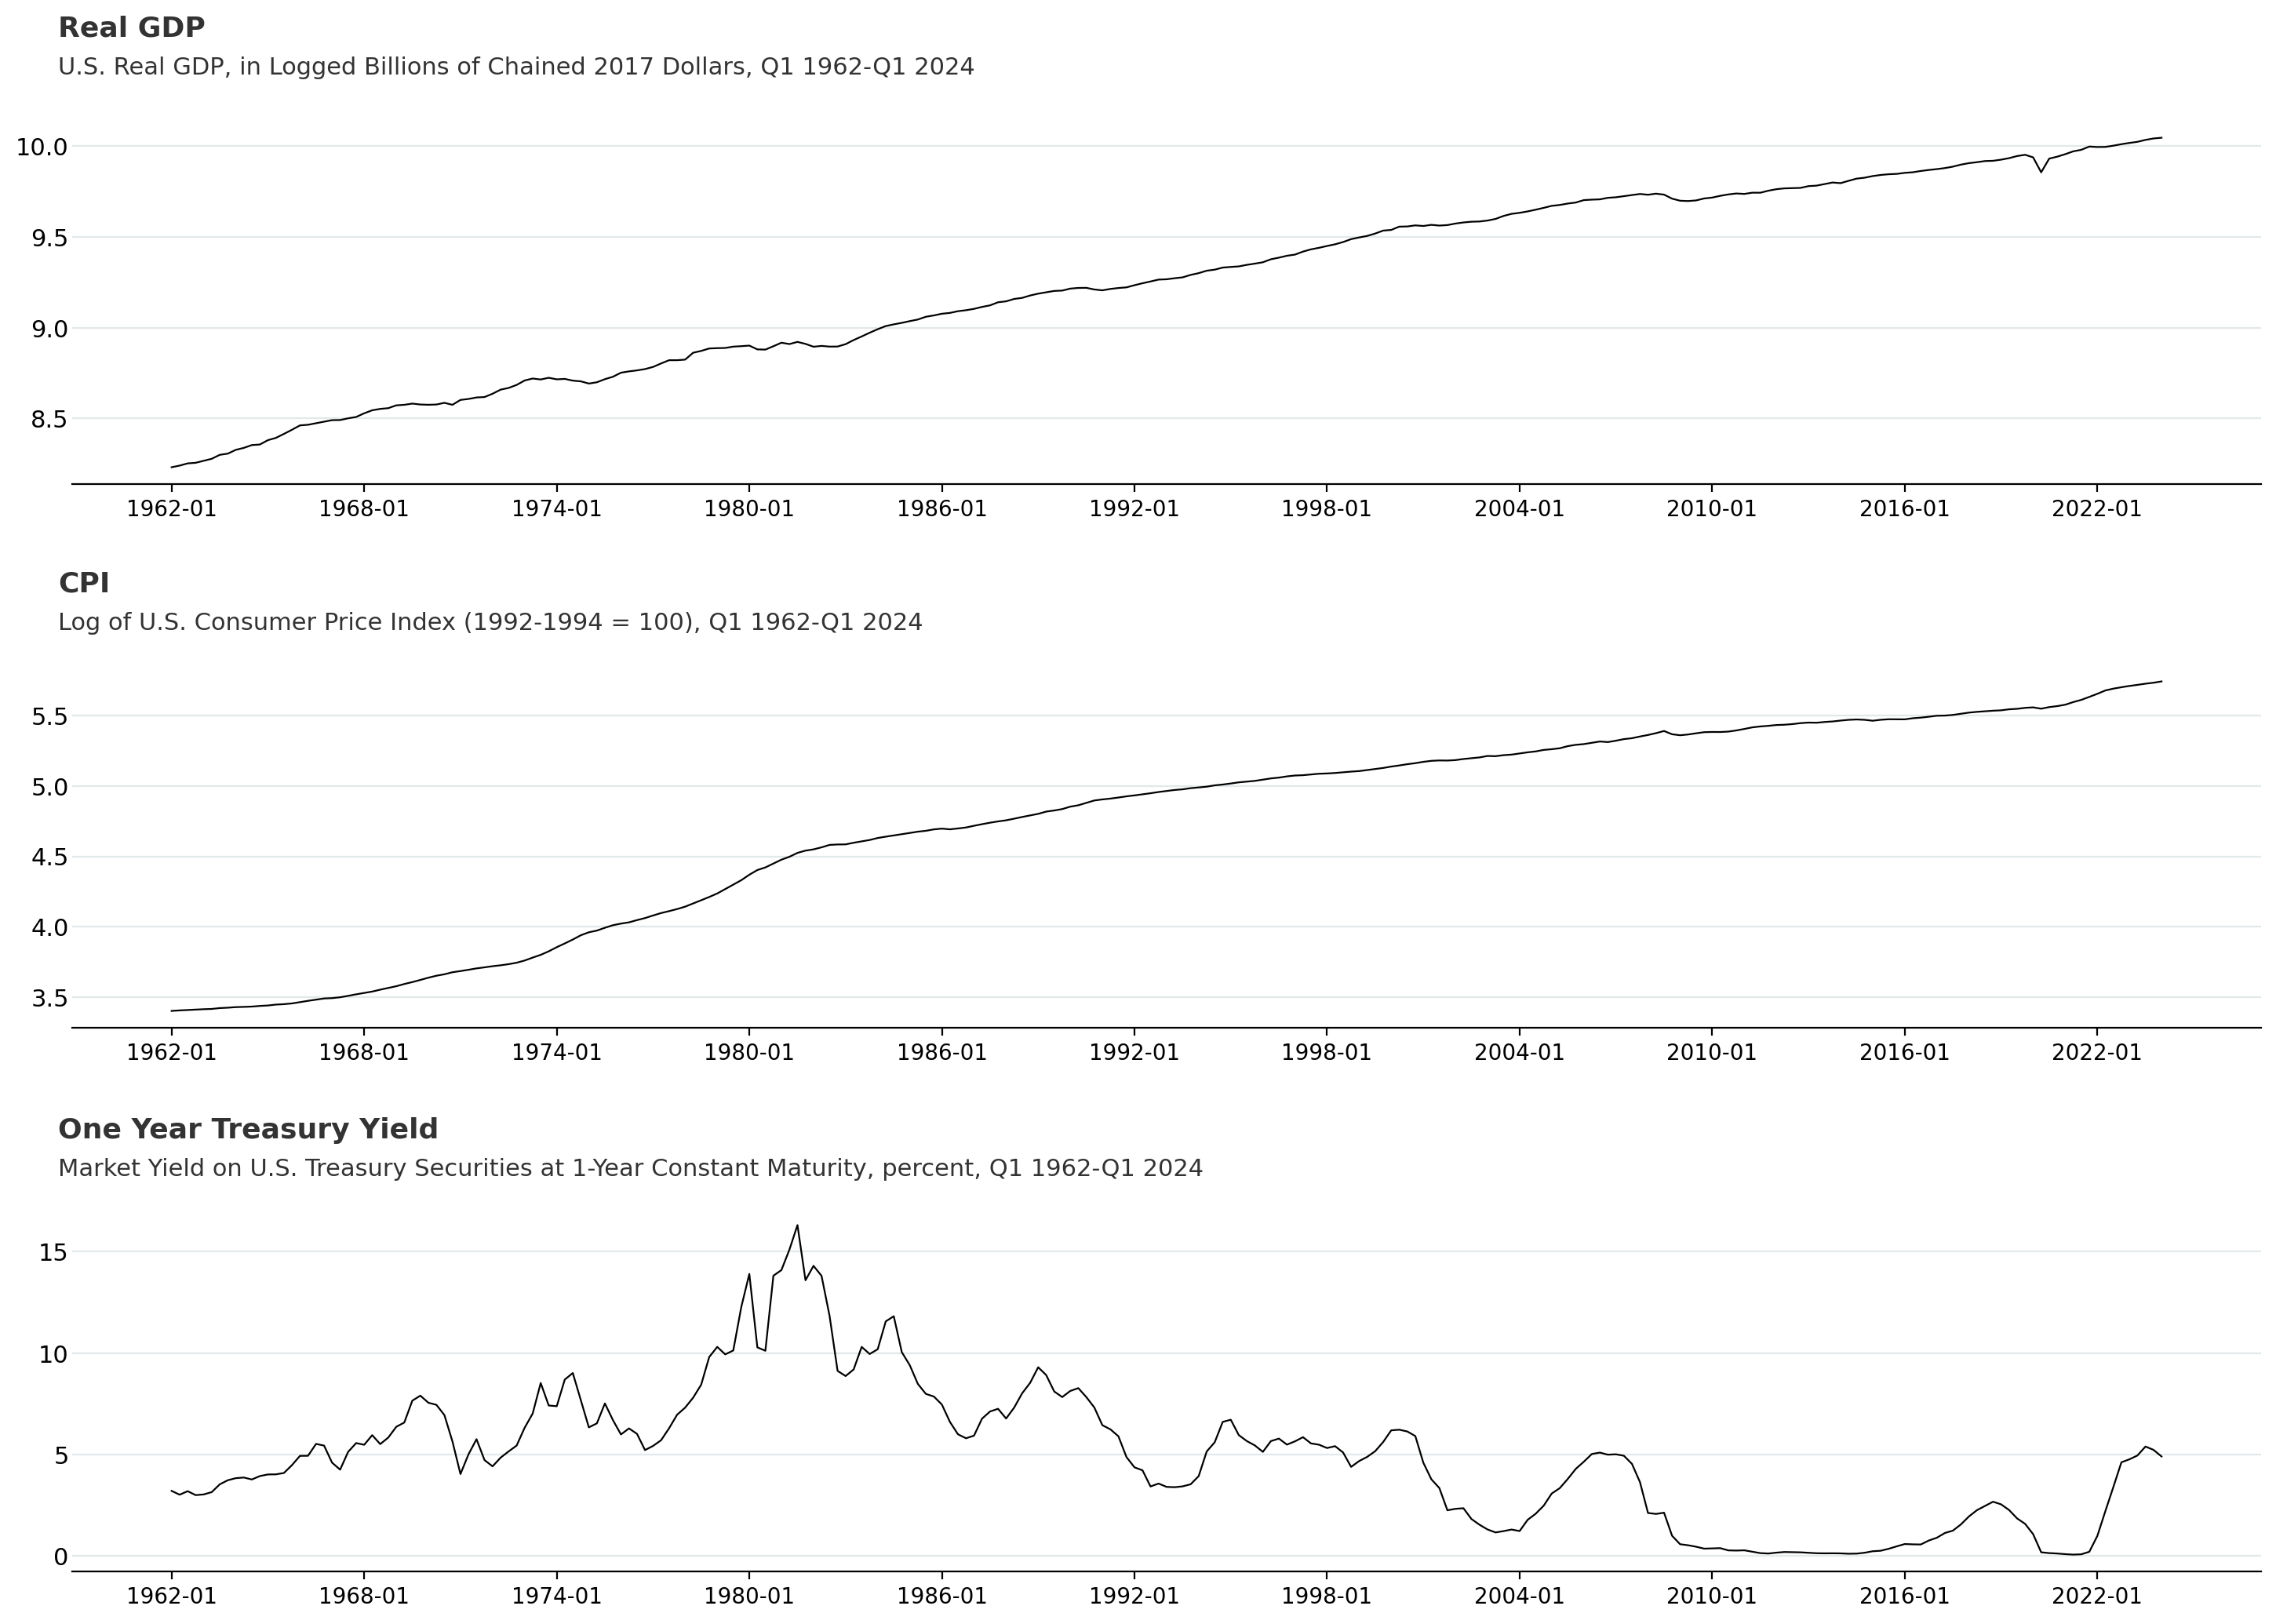

In [27]:
#----------------------- Plot the data
data_fig_1, data_ax_1 = plt.subplots(nrows = 3, ncols = 1, figsize = (18, 12))

# Get the dates
dates = pd.date_range(start = "1962-01", end = "2024-01", freq = "QS")

# Real GDP plot
data_ax_1[0].plot(log_rgdp, color = "black", linewidth = 0.8)

data_ax_1[0].set_xticks(range(0, len(dates), len(dates) // 10))
data_ax_1[0].set_xticklabels([date.strftime("%Y-%m") for date in dates[::len(dates) // 10]])

data_ax_1[0].text(x = 0.12, y = .925, s="Real GDP", transform=data_fig_1.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
data_ax_1[0].text(x=0.12, y=.905, s="U.S. Real GDP, in Logged Billions of Chained 2017 Dollars, Q1 1962-Q1 2024", transform=data_fig_1.transFigure, ha='left', fontsize=11, alpha=.8);

# CPI plot
data_ax_1[1].plot(log_cpi, color = "black", linewidth = 0.8)

data_ax_1[1].set_xticks(range(0, len(dates), len(dates) // 10))
data_ax_1[1].set_xticklabels([date.strftime("%Y-%m") for date in dates[::len(dates) // 10]])

data_ax_1[1].text(x = 0.12, y = 0.63, s="CPI", transform=data_fig_1.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
data_ax_1[1].text(x=0.12, y=.61, s="Log of U.S. Consumer Price Index (1992-1994 = 100), Q1 1962-Q1 2024", transform=data_fig_1.transFigure, ha='left', fontsize=11, alpha=.8);

# GS1 Plot
data_ax_1[2].plot(gs1, color = "black", linewidth = 0.8)

data_ax_1[2].set_xticks(range(0, len(dates), len(dates) // 10))
data_ax_1[2].set_xticklabels([date.strftime("%Y-%m") for date in dates[::len(dates) // 10]])

data_ax_1[2].text(x = 0.12, y = 0.34, s="One Year Treasury Yield", transform=data_fig_1.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
data_ax_1[2].text(x=0.12, y=.32, s="Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, percent, Q1 1962-Q1 2024", transform=data_fig_1.transFigure, ha='left', fontsize=11, alpha=.8);

for ax in data_ax_1:
    ax.grid(which="major", axis='y', color='#758D99', alpha=0.2, zorder=1)
    ax.spines[['top','right','left']].set_visible(False)
    ax.yaxis.set_tick_params(pad = -2, bottom = False, labelsize = 11)

plt.subplots_adjust(hspace = 0.5)

In [28]:
#----------------------- Transform the data
rgdp_growth = np.diff(log_rgdp) * 400
inflation = np.diff(log_cpi) * 100
gs1 = gs1[1:]

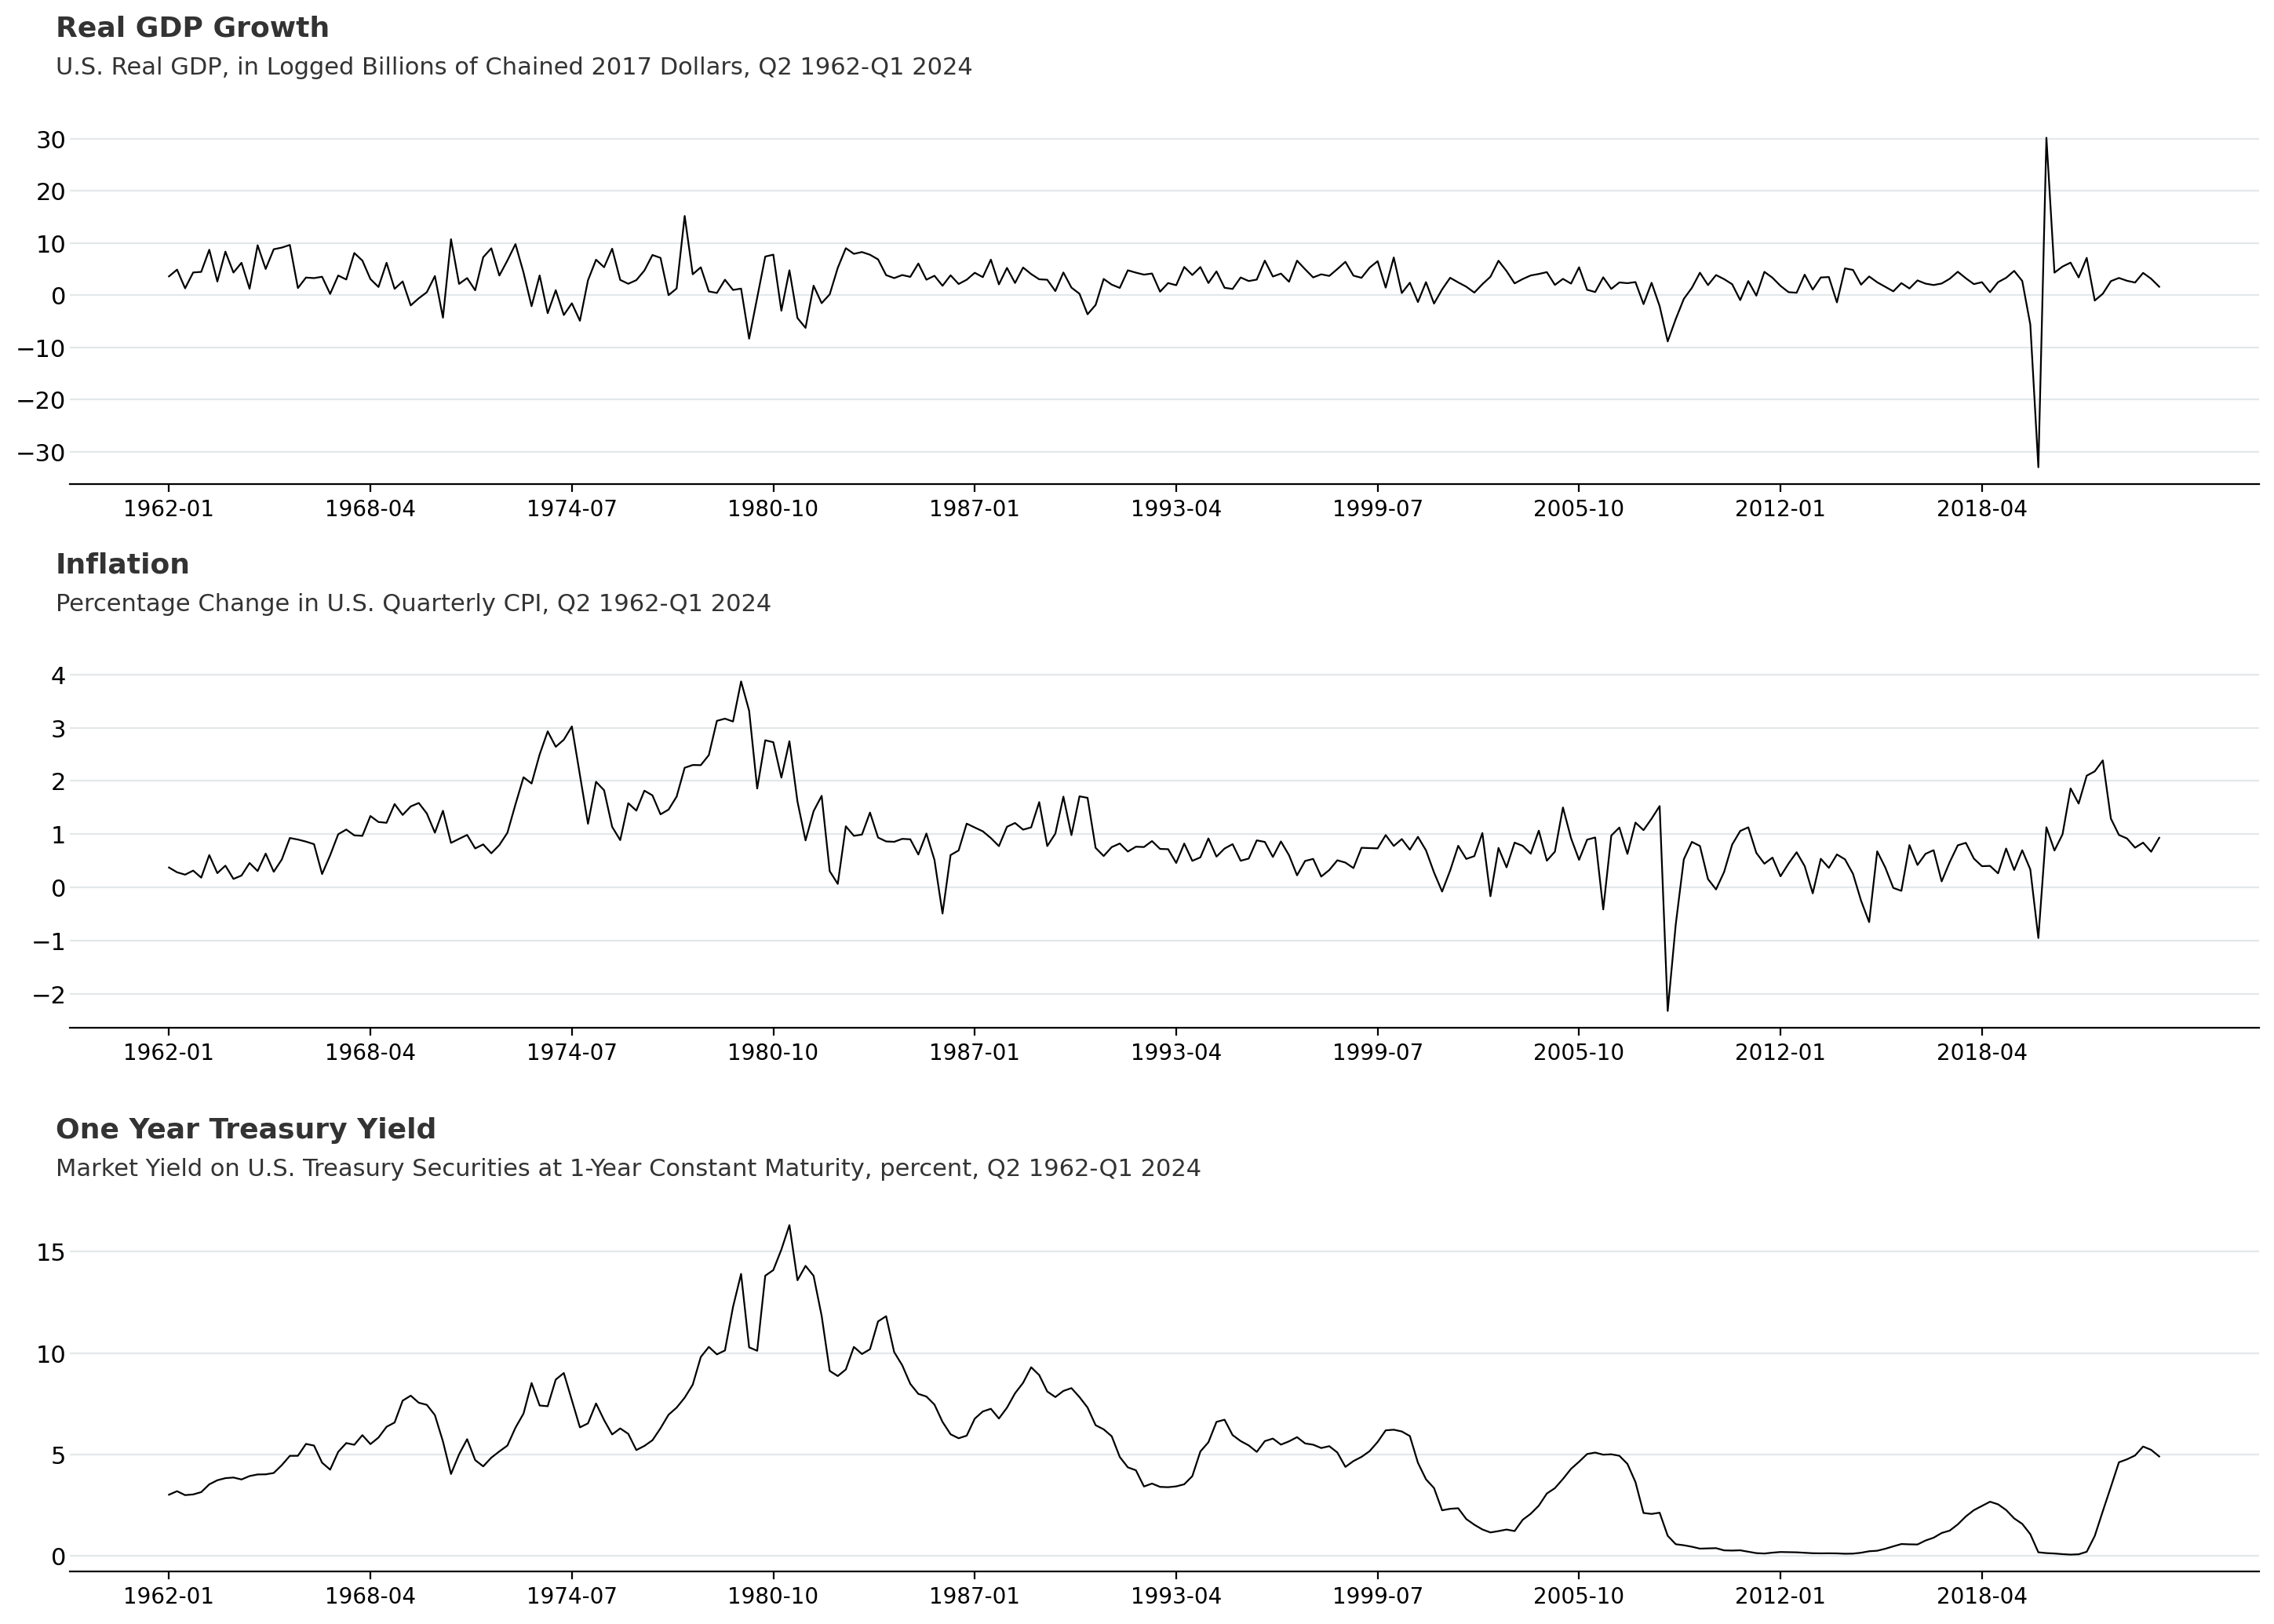

In [29]:
#----------------------- Plot the transformed data
data_fig_2, data_ax_2 = plt.subplots(nrows = 3, ncols = 1, figsize = (18, 12))

# Get the dates
transformed_dates = pd.date_range(start = "1962-01", end = "2024-04", freq = "QS")

# Real GDP plot
data_ax_2[0].plot(rgdp_growth, color = "black", linewidth = 0.8)

data_ax_2[0].text(x = 0.12, y = .925, s="Real GDP Growth", transform=data_fig_2.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
data_ax_2[0].text(x=0.12, y=.905, s="U.S. Real GDP, in Logged Billions of Chained 2017 Dollars, Q2 1962-Q1 2024", transform=data_fig_2.transFigure, ha='left', fontsize=11, alpha=.8);

# CPI plot
data_ax_2[1].plot(inflation, color = "black", linewidth = 0.8)

data_ax_2[1].text(x = 0.12, y = 0.64, s="Inflation", transform=data_fig_2.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
data_ax_2[1].text(x=0.12, y=.62, s="Percentage Change in U.S. Quarterly CPI, Q2 1962-Q1 2024", transform=data_fig_2.transFigure, ha='left', fontsize=11, alpha=.8);

# GS1 Plot
data_ax_2[2].plot(gs1, color = "black", linewidth = 0.8)

data_ax_2[2].text(x = 0.12, y = 0.34, s="One Year Treasury Yield", transform=data_fig_2.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
data_ax_2[2].text(x=0.12, y=.32, s="Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, percent, Q2 1962-Q1 2024", transform=data_fig_2.transFigure, ha='left', fontsize=11, alpha=.8);

for ax in data_ax_2:
    ax.grid(which="major", axis='y', color='#758D99', alpha=0.2, zorder=1)
    ax.spines[['top','right','left']].set_visible(False)
    ax.yaxis.set_tick_params(pad = -2, bottom = False, labelsize = 11)

    ax.set_xticks(range(0, len(transformed_dates), len(transformed_dates) // 10))
    ax.set_xticklabels([date.strftime("%Y-%m") for date in transformed_dates[::len(transformed_dates) // 10]])

plt.subplots_adjust(hspace = 0.5)

# The Model
The standard reduced form VAR(p) model can be written in the form:
$$
y_t = \mu + \sum_{\ell = 1}^p \Phi_\ell y_{t - \ell} + \varepsilon_t
$$
where $y_t$ consists of a set of $k$ variables, $\mu \in \mathbb R^k$, $\Phi_1, \ldots, \Phi_p \in \mathbb R^{k, k}$, and $\varepsilon_t \sim (0, \Sigma_\varepsilon)$ is an
$\mathbb R^k$-valued white noise process.

In the present example, $y_t$ consists of the growth rate of real GDP, CPI inflation, and the one year Treaury yield.

## VAR Model Selection
In this section, we implement standard procedures for estimating the optimal lag order, $p$, with which to estimate the VAR. In particular, we make use of information criteria, which seeks to balance the trade off between improving the in sample fit of the VAR by choosing a higher lag order, and reducing overfitting by choosing a more parsimonious model. Thus, information criteria seek to minimise a function of the lag order that incorporates the model fit, while penalising a higher lag order. The fit of the model is measured by:
$$
\ln |\hat \Sigma_\varepsilon(j)|
$$
where $\hat \Sigma_\varepsilon(j)$ is the residual covariance matrix computed based on a VAR(j). The penalty term for the model size takes the form:
$$
f(T) \varphi(j)
$$
where $f$ is a function of the sample size used to estimate the VAR and $\varphi$ is some function of the lag order, such that larger samples are penalised less. We consider the use of three information criteria, the AIC, HQC, and the BIC. The corresponding penalty terms are:
$$
\begin{align*}
f_{\text{AIC}}(T) = 2 T^{-1} && f_{\text{HQC}}(T) = 2 T^{-1} \ln \ln T && f_{\text{BIC}}(T) = T^{-1} \ln T 
&& \varphi_{\text{AIC}}(j) = \varphi_{\text{HQC}}(j) = \varphi_{\text{BIC}} = jk^2 + k
\end{align*}
$$

To implement the lag order selection procedure, we choose a maximum lag order of 24, and compute the information criteria values accordingly. For each lag order $j$, the VAR models are estimated using the same number of observations.

In [30]:
var_data = np.column_stack((rgdp_growth, inflation, gs1))

In [31]:
var_lag_order_selector = VARLagOrderSelector()
max_lag = 24
var_lag_order_selector.compute_lag_order_statistics(data = var_data, max_lag = max_lag)

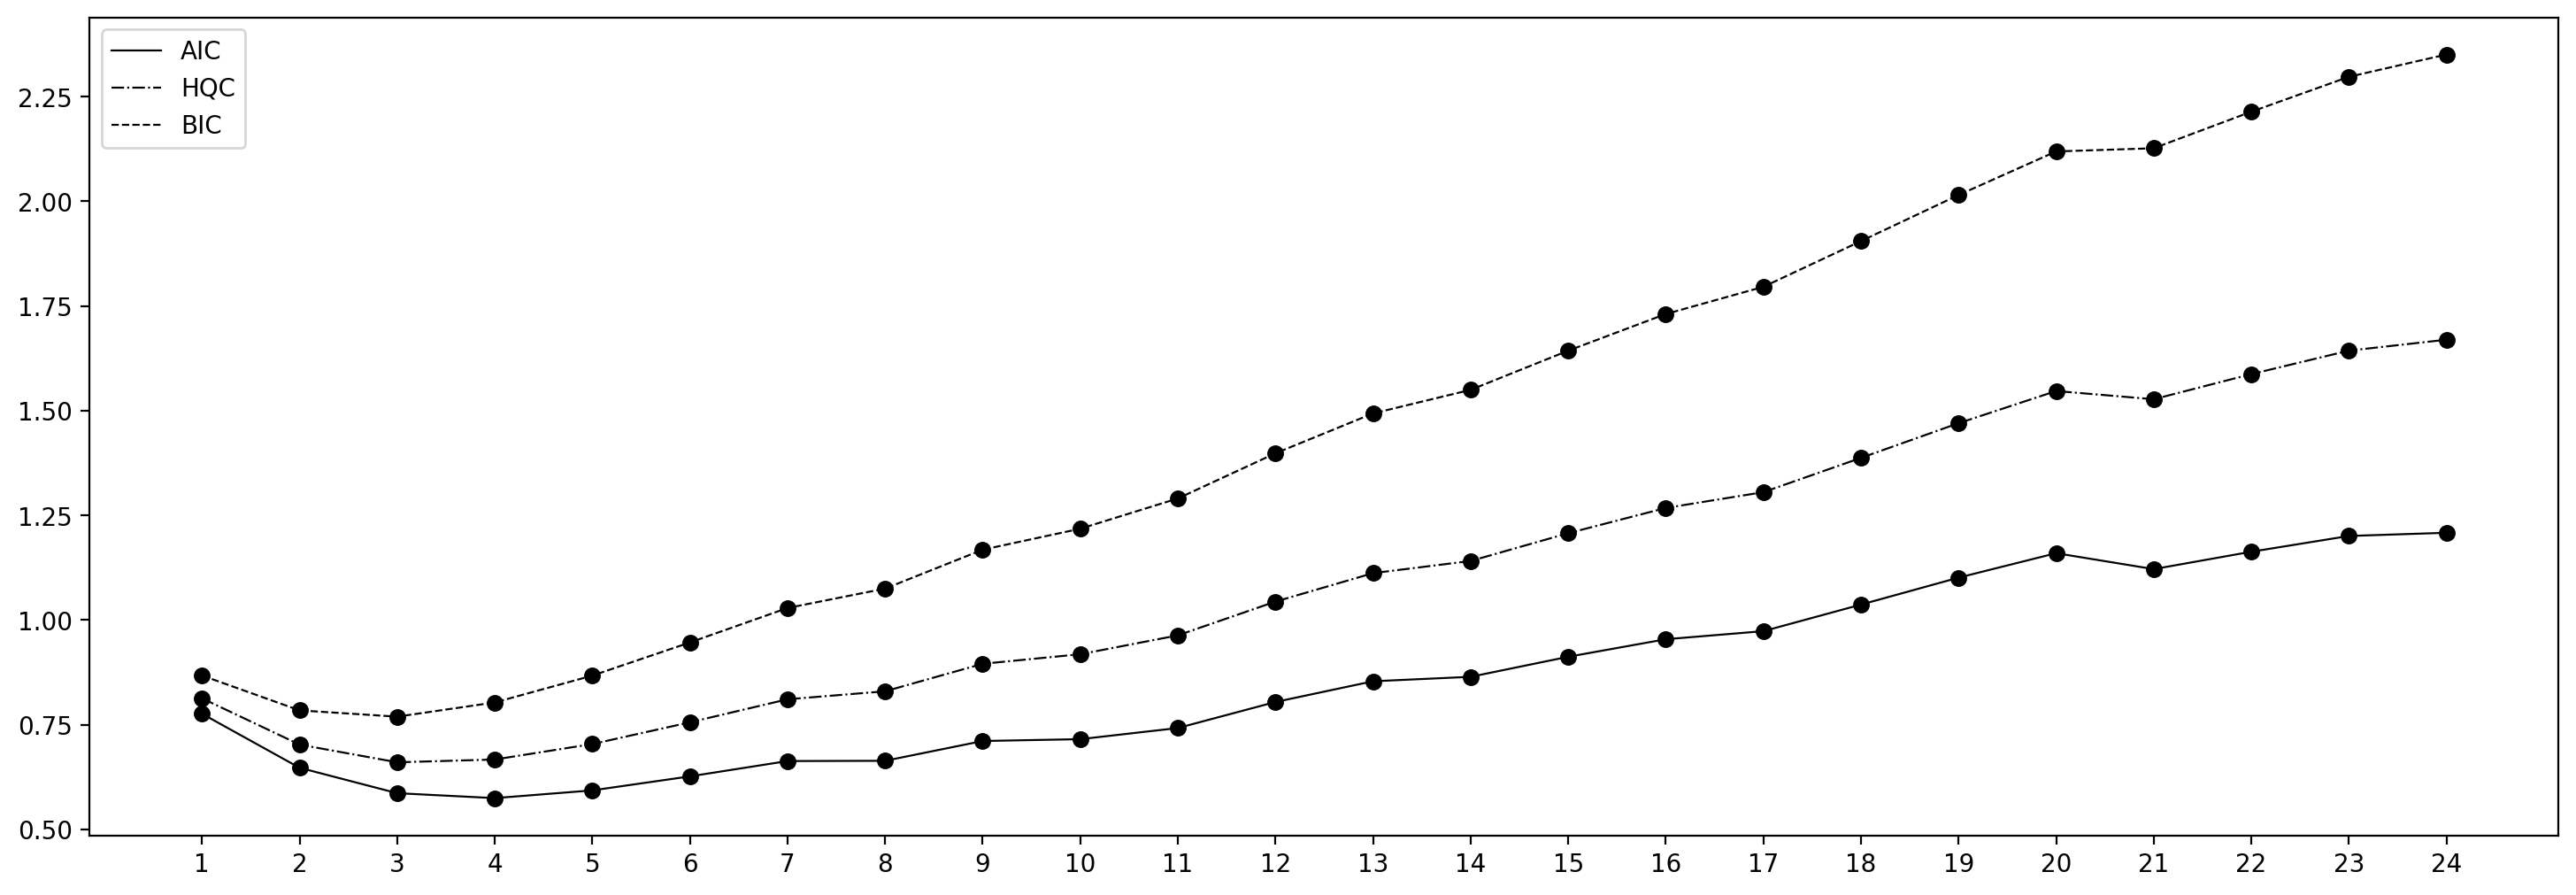

In [32]:
lag_order_fig, lag_order_ax = plt.subplots(figsize = (18, 6))

lag_order_ax.plot(range(1, max_lag + 1), var_lag_order_selector.aic_values, color = "black", linewidth = 0.8, label = "AIC")
lag_order_ax.scatter(range(1, max_lag + 1), var_lag_order_selector.aic_values, color = "black", linewidth = 0.8)

lag_order_ax.plot(range(1, max_lag + 1), var_lag_order_selector.hqc_values, color = "black", linewidth = 0.8, linestyle = "-.", label = "HQC")
lag_order_ax.scatter(range(1, max_lag + 1), var_lag_order_selector.hqc_values, color = "black", linewidth = 0.8)

lag_order_ax.plot(range(1, max_lag + 1), var_lag_order_selector.bic_values, color = "black", linewidth = 0.8, linestyle = "--", label = "BIC")
lag_order_ax.scatter(range(1, max_lag + 1), var_lag_order_selector.bic_values, color = "black", linewidth = 0.8)

lag_order_ax.set_xticks(range(1, max_lag + 1))

plt.legend();

# Estimation
If we define $z_{t-1} = (1, y_{t-1}, \ldots, y_{t-p})$ and $\Phi_+ = \begin{bmatrix}\mu & \Phi_1 & \cdots & \Phi_p\end{bmatrix}$, we can write the model more compactly as:
$$
y_t = \Phi_+ z_{t-1} + \varepsilon_t
$$

Moreover, the data matrix representation is:
$$
Y_t = \Phi_+ Z + E
$$

where $Y, Z, and E$ are matrices of observations on $y_t, z_{t-1}$, and the corresponding unobserved errors. The least squares estimator of $\Phi_+$ is:
$$
\hat \Phi_+ = Y Z' {(ZZ')}^{-1}
$$

In [33]:
macro_var = VARModel()
macro_var.estimate_ols(data = var_data, num_lags = 4)

In [34]:
μ, Φ_mats = macro_var.μ, macro_var.Φ_mats

print("Estimates of μ:")
print(μ)

for i in range(len(Φ_mats)):
    print(f"Estimates of Φ_{i + 1}:")
    print(Φ_mats[i])

Estimates of μ:
[ 3.38604071  0.14037664 -0.16078183]
Estimates of Φ_1:
[[-0.02576243 -0.65132138  0.84864203]
 [-0.00574303  0.53711584  0.18788247]
 [ 0.03331206 -0.06598204  1.21467646]]
Estimates of Φ_2:
[[ 0.08940982 -0.4676311  -1.59996227]
 [ 0.0030751   0.02713139 -0.24030562]
 [ 0.0235687   0.30942535 -0.61433935]]
Estimates of Φ_3:
[[ 0.00501492  0.05441338  1.14394049]
 [ 0.00300083  0.2360857   0.10659345]
 [ 0.0078197  -0.01580182  0.56727007]]
Estimates of Φ_4:
[[ 0.03932807 -0.74304665 -0.20497903]
 [ 0.00335579 -0.04278062 -0.03774469]
 [ 0.00850161  0.08911719 -0.23786006]]


## Model Diagnostics
In this section, we conduct several tests designed to evaluate whether the VAR model specification is an accurate description of the underlying data generating process. In particular, the tests we consider are based on the premise that if the data generating process is correctly specified by the VAR(p) equation with white noise errors, then the residuals $\hat \varepsilon = y_t - \hat \Phi z_{t-1}$ form a white noise process. If we can reject the hypothesis that the residuals are white noise, then we should reject the premise that the data generating process is a VAR(p).

Below, we plot the residuals from the estimated VAR(4) model for each of the variables.

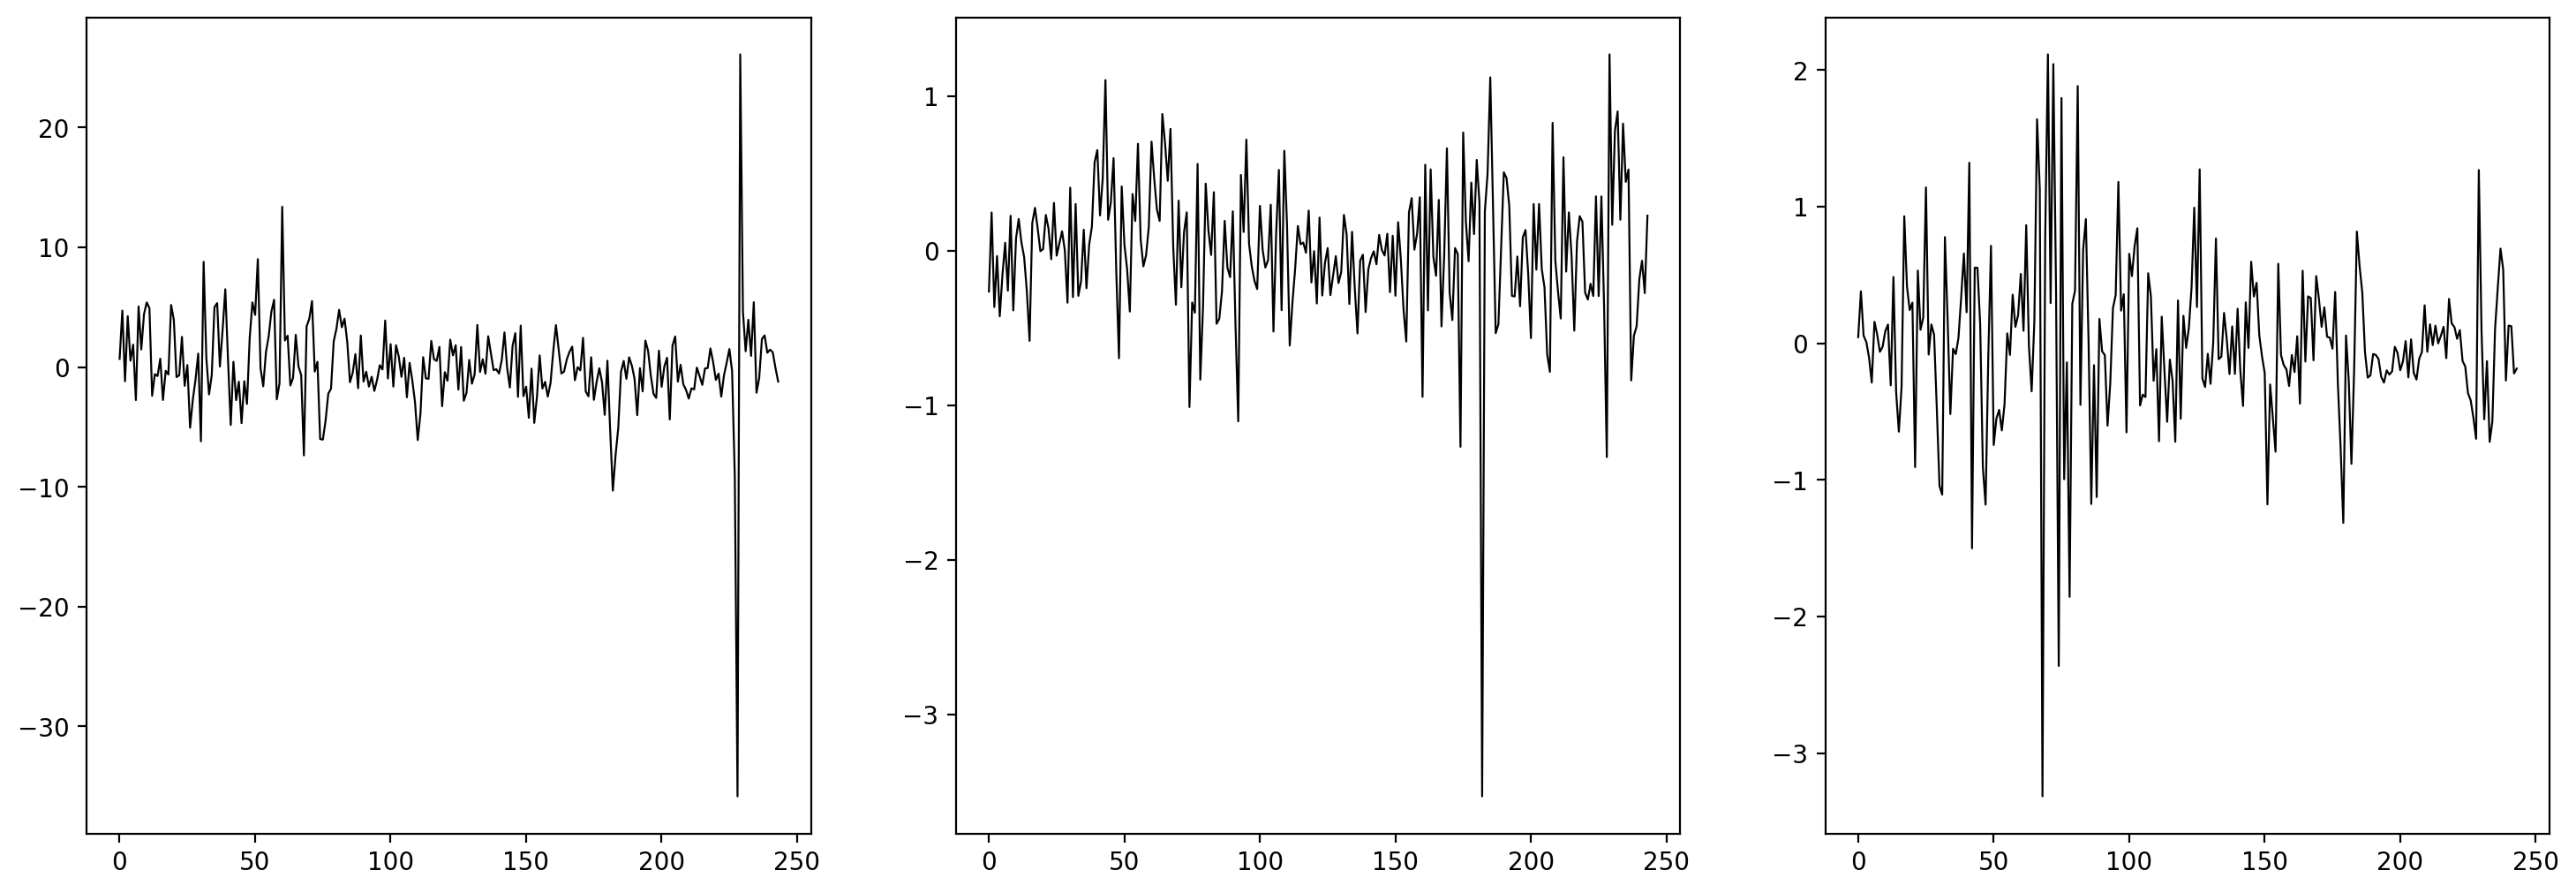

In [35]:
gdp_growth_resids = macro_var.resids[0, :]
inflation_resids = macro_var.resids[1, :]
gs1_resids = macro_var.resids[2, :]

resids_fig, resids_ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 6))

resids_ax[0].plot(gdp_growth_resids, color = "black", linewidth = 0.8)
resids_ax[1].plot(inflation_resids, color = "black", linewidth = 0.8)
resids_ax[2].plot(gs1_resids, color = "black", linewidth = 0.8);

### Testing the Significance of the Residual Autocovariances
The first test we consider is based on the significance of the residual autocovariances. Letting $\hat \varepsilon$ denote the $T \times k$ matrix of residuals, the autocovariance at lag $h$ is estimated by:
$$
\hat C_h = T^{-1} \hat \varepsilon' F_h \hat \varepsilon
$$
where $F_h$ is a $T \times T$ matrix with ones on the $h$-th subdiagonal and zeros elsewhere. The autocorrelation at lag $h$ is then estimated by:
$$
\hat R_h = \hat D^{-1} \hat C_h \hat D^{-1}
$$
where $\hat D$ is a diagonal matrix with the square root diagonal elements of $\hat C_0$ on the diagonal. Letting $\hat {\bf{R}}_h = (\hat R_1, \ldots, \hat R_h)$ denote the vector of autocorrelations at lags $1, \ldots, h$, and $\hat {\bf r}_h = \text{vec} (\hat {\bf R}_h)$, we have, by Proposition 4.6 of Lütkepohl (2006), that:
$$
\begin{align*}
    & T^{\frac 12} \hat {\bf r}_h \rightsquigarrow N(0, \Sigma_{\bf r}(h)) \\
    & \Sigma_{\bf r}(h) = [(I_h \otimes R_u) - G'_0 \Gamma^{-1} G_0] \otimes R_u
\end{align*}
$$
which allows us to construct asymptotic standard errors for the autocorrelations.

In [36]:
resid_test_max_lag = 20
est_autocorr, std_errs = estimate_residual_autocorrelations(macro_var, resid_test_max_lag)

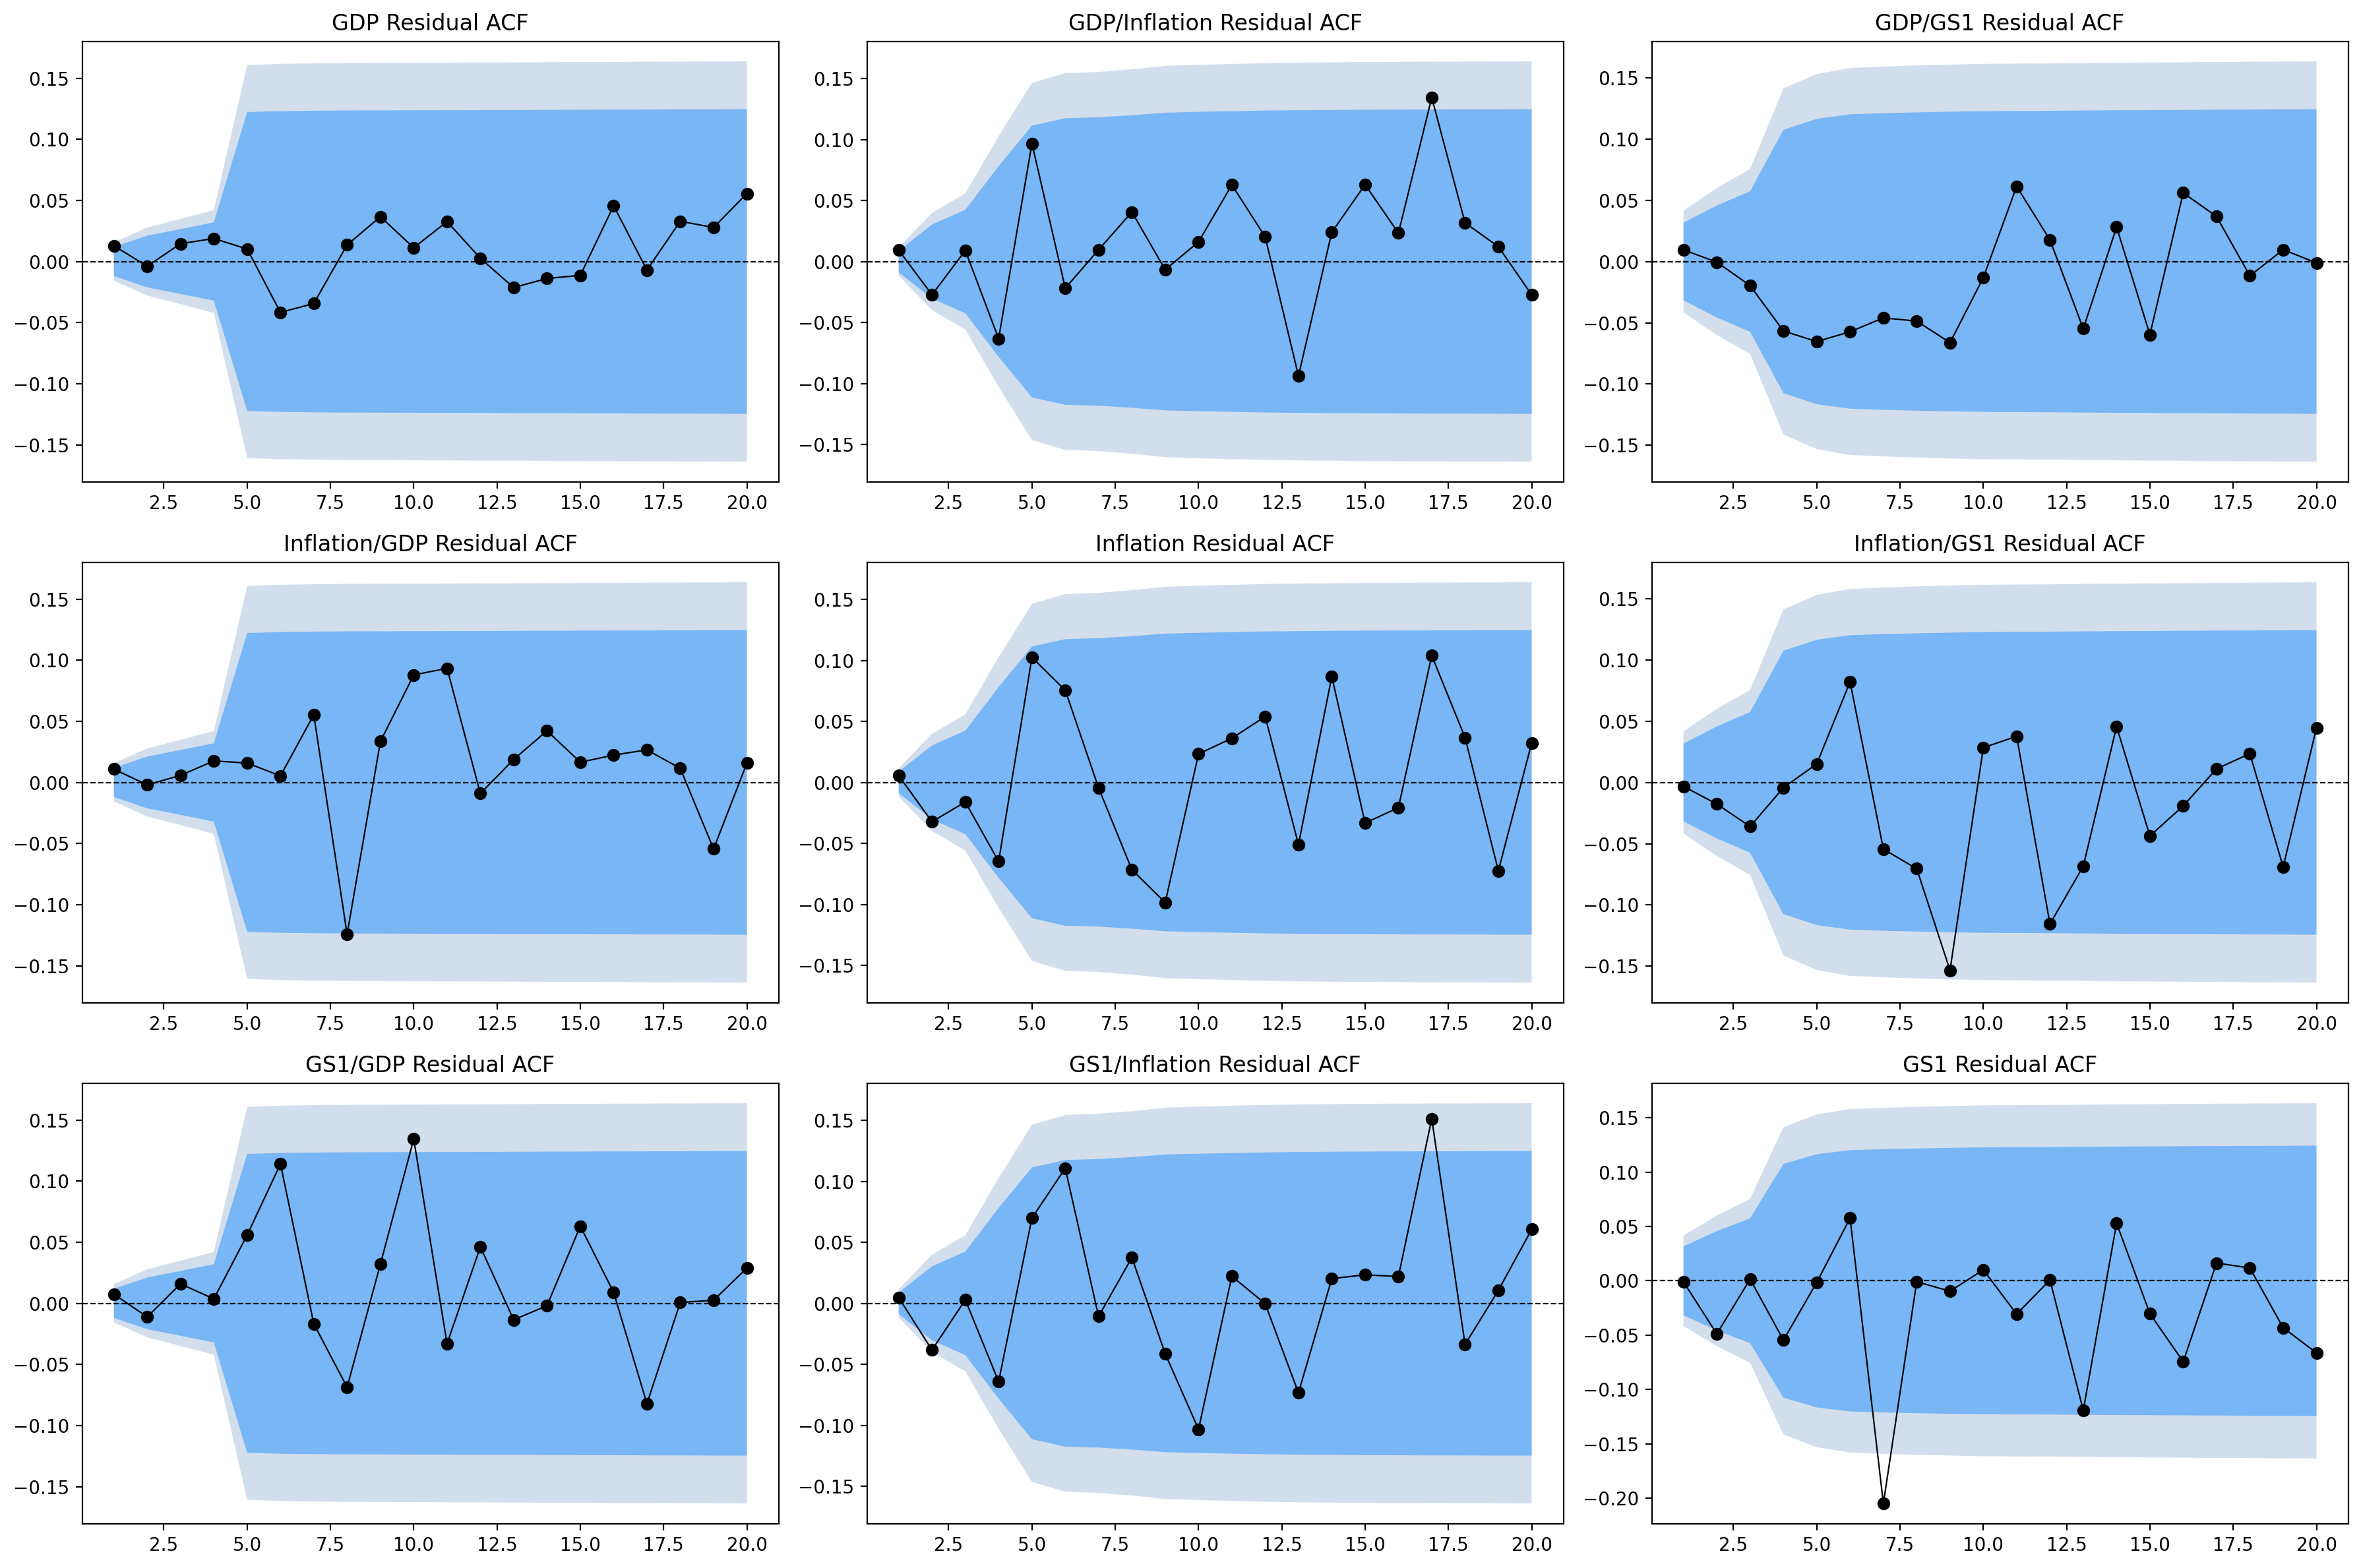

In [37]:
acf_fig, acf_ax = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 12))

acf_fig_titles = [
    "GDP Residual ACF", "GDP/Inflation Residual ACF", "GDP/GS1 Residual ACF",
    "Inflation/GDP Residual ACF", "Inflation Residual ACF", "Inflation/GS1 Residual ACF",
    "GS1/GDP Residual ACF", "GS1/Inflation Residual ACF", "GS1 Residual ACF"
]

for i in range(3):
    for j in range(3):
        acf_ax[i, j].fill_between(range(1, resid_test_max_lag + 1), [-2.576 * std_errs[h][i][j] for h in range(resid_test_max_lag)], [2.576 * std_errs[h][i][j] for h in range(resid_test_max_lag)], color = "lightsteelblue", alpha = 0.55, edgecolor = "none")
        acf_ax[i, j].fill_between(range(1, resid_test_max_lag + 1), [-1.96 * std_errs[h][i][j] for h in range(resid_test_max_lag)], [1.96 * std_errs[h][i][j] for h in range(resid_test_max_lag)], color = "dodgerblue", alpha = 0.5, edgecolor = "none")
        acf_ax[i, j].plot(range(1, resid_test_max_lag + 1), [est_autocorr[h][i][j] for h in range(resid_test_max_lag)], color = "black", linewidth = 0.8)
        acf_ax[i, j].scatter(range(1, resid_test_max_lag + 1), [est_autocorr[h][i][j] for h in range(resid_test_max_lag)], color = "black")

        acf_ax[i, j].axhline(y = 0, color = "black", linewidth = 0.8, linestyle = "--")

        acf_ax[i, j].set_title(acf_fig_titles[3 * i + j])

plt.tight_layout()

## Forecasting
In this section, we use the estimated models to produce point and interval forecasts for real GDP growth, inflation, and the one year Treasury yield.

The forecasting exercise can be expressed in the statistical decision-theoretic framework as follows. The stochastic process under examination is ${\{y_t\}}_{t \in \mathbb Z}$, where for each $t$, $y_t$ is $\mathbb R^k$-valued. At some time period $t$, given some information set $\Omega_t$, our objective is to predict the value of $y_{t+h}$. To assess the accuracy of our predicted value, which we denote $\tilde y_{t}(h)$, we specify a loss function $\mathcal L(\tilde y_{t}(h), y_{t+h})$, whose expectation we seek to minimise, conditional on $\Omega_t$. That is we choose the forecast:
$$
\tilde y^*_{t}(h) \in \arg \min_{\hat y_{t}(h)} \int \mathcal L(\tilde y_{t}(h), y_{t+h}) d\mathbb P_{y_{t+h}|\Omega_t}
$$
where $\mathbb P_{y_{t+h}|\Omega_t}$ denotes the distribution of $y_{t+h}$, conditional on $\Omega_t$. As is standard, we use the quadratic loss function, in which case the minimiser is the conditional mean:
$$
\tilde y_{t}^*(h) = \mathbb E[y_{t+h} | \Omega_t]
$$

Moreover, the information set is the filtration defined by $\Omega_t = {\{\sigma(y_\tau)\}}_{\tau \le t}$. In the case where we assume ${\{y_t\}}_{t \in \mathbb Z}$ is generated by a VAR(p) process with independent white noise errors, we have:
$$
\tilde y_{t}^*(h) = \mu + \sum_{\ell = 1}^p \Phi_{\ell} \tilde y_{t}^*(h - \ell)
$$

Otherwise, the above equation characterises the optimal linear predictor of $y_{t+h}$. 

### Computing the Point Forecasts
To compute the forecasts, we replace the coefficient matrices with their least squares estimates. We denote the corresponding predictions by $\hat y_t(h)$. From here, the computation of the forecasts is simple. We have:
$$
\hat y_t(h) = J \bar {\boldsymbol {\Gamma}}^h Z_t
$$
where:
$$
\begin{align*}
J = \begin{bmatrix}
0_{k, 1} & I_k & 0_{k, k(p - 1)}
\end{bmatrix}
&&
\bar {\boldsymbol {\Gamma}} = \begin{bmatrix}
1 & & 0_{kp}\\
&\Gamma
\end{bmatrix}
&&
Z_t = (1, y_t, \ldots, y_{t-p+1})
\end{align*}
$$

### The MSE of the Forecasts
Under standard conditions sufficient for the consistency and asymptotic normality of the least squares estimates, we have:
$$
T^{\frac 12}(\hat y_t(h) - \tilde y_t^*(h)) \rightsquigarrow N(0, \text{Asy.} \mathbb V[\hat y_t(h)])
$$

Under general conditions, the forecast errors are unbiased, and the MSE of $\hat y_t(h)$ can be approximated by:
$$
\Sigma_{\hat y}(h) = \Sigma_{y^*}(h) + T^{-1} \Omega(h)
$$
where $\Sigma_{y^*}(h)$ is the MSE of the optimal forecast computed using the coefficients $\Delta_i$ in the VMA representation:
$$
\Sigma_{y^*}(h) = \sum_{\ell = 0}^{h - 1} \Delta_i \Sigma_\epsilon \Delta_i'
$$
and:
$$
\Omega(h) = \sum_{\ell = 0}^{h - 1} \sum_{\mathcal j = 0}^{h-1} \text{tr}{\left(
    (\bar {\boldsymbol {\Gamma}}')^{h - 1 - \ell} \hat \Lambda^{-1} \bar {\boldsymbol {\Gamma}}^{h - 1 - \mathcal j} \hat \Lambda
\right)}  \Delta_\ell \Sigma_\varepsilon \Delta_{\mathcal j}'
$$
with $\hat \Lambda = T^{-1}ZZ'$.

### Forecast Results
Below, the point and interval forecasts for the three series, for Q2 2024 through Q1 2026 are plotted.

In [38]:
# Define the maximum forecast horizon to be eight quarters
max_forecast_horizon = 8

# Compute the forecasts and forecast MSEs for each horizon
forecasts = [macro_var.forecast(horizon = horizon) for horizon in range(max_forecast_horizon + 1)]

In [39]:
rgdp_growth_forecasts = [forecasts[h][0][0][0] for h in range(max_forecast_horizon + 1)]
rgdp_growth_forecast_MSEs = [forecasts[h][1][0][0] for h in range(max_forecast_horizon + 1)]

inflation_forecasts = [forecasts[h][0][1][0] for h in range(max_forecast_horizon + 1)]
inflation_forecast_MSEs = [forecasts[h][1][1][1] for h in range(max_forecast_horizon + 1)]

gs1_forecasts = [forecasts[h][0][2][0] for h in range(max_forecast_horizon + 1)]
gs1_forecast_MSEs = [forecasts[h][1][2][2] for h in range(max_forecast_horizon + 1)]

data_graphs = [rgdp_growth, inflation, gs1]
forecast_graphs = [rgdp_growth_forecasts, inflation_forecasts, gs1_forecasts]
forecast_graphs_MSEs = [rgdp_growth_forecast_MSEs, inflation_forecast_MSEs, gs1_forecast_MSEs]

In [ ]:
#----------------------- Plot the forecasts
forecast_plot_dates = pd.date_range(start = "2000-01", end = "2026-04", freq = "QS")

forecasts_fig, forecasts_ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 6))

forecast_plot_titles = ["Real GDP Growth", "Inflation", "One Year Treasury Yield"]

for i, ax in enumerate(forecasts_ax):
    data_graph = data_graphs[i]
    forecast_graph = forecast_graphs[i]
    forecast_graph_MSEs = forecast_graphs_MSEs[i]

    ax.plot(np.arange(0, len(data_graph[152:])), data_graph[152:], color = "black", linewidth = 0.8)

    ax.fill_between(
        np.arange(len(data_graph[152:]) - 1, len(data_graph[152:]) + max_forecast_horizon, 1),
        [forecast_graph[h] + 1.65 * np.sqrt(forecast_graph_MSEs[h]) for h in range(max_forecast_horizon + 1)],
        [forecast_graph[h] - 1.65 * np.sqrt(forecast_graph_MSEs[h]) for h in range(max_forecast_horizon + 1)],
        color = "lightsteelblue",
        alpha = 0.55,
        edgecolor = "none"
    )

    ax.fill_between(
        np.arange(len(data_graph[152:]) - 1, len(data_graph[152:]) + max_forecast_horizon, 1),
        [forecast_graph[h] + 0.67 * np.sqrt(forecast_graph_MSEs[h]) for h in range(max_forecast_horizon + 1)],
        [forecast_graph[h] - 0.67 * np.sqrt(forecast_graph_MSEs[h]) for h in range(max_forecast_horizon + 1)],
        color = "dodgerblue",
        alpha = 0.5,
        edgecolor = "none"
    )

    ax.plot(
        np.arange(len(data_graph[152:]) - 1, len(data_graph[152:]) + max_forecast_horizon, 1),
        forecast_graph,
        color = "blue",
        linewidth = 0.8
    )

    ax.set_xticks(range(0, len(forecast_plot_dates), len(forecast_plot_dates) // 5))
    ax.set_xticklabels([date.strftime("%Y-%m") for date in forecast_plot_dates[::len(forecast_plot_dates) // 5]])

    ax.set_title(forecast_plot_titles[i])